# Time series project

In [546]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [547]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    thr = np.quantile(W[W > 0], 0.90)
    print(f"The threshold is: {thr}") 
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [548]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 6.984919309616089e-10


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [4.07462600e-16 6.98009359e-16 1.63064001e-15 1.73182896e+00
 1.73719281e+00 2.27490200e+00 2.65115474e+00 2.97658905e+00
 2.99102485e+00 3.01184065e+00]


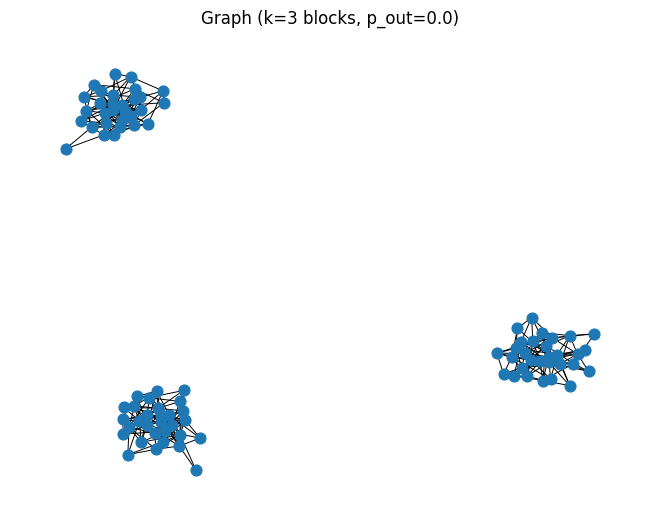

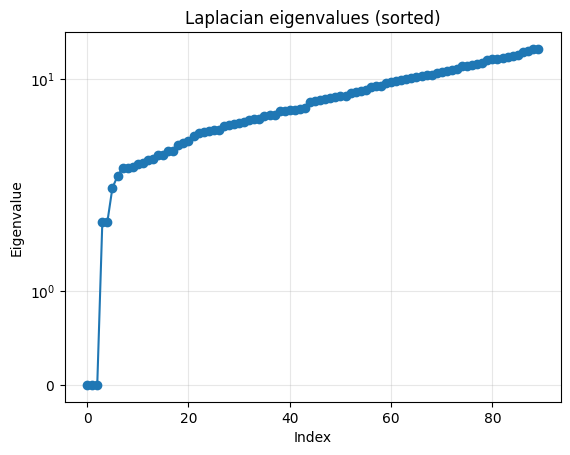

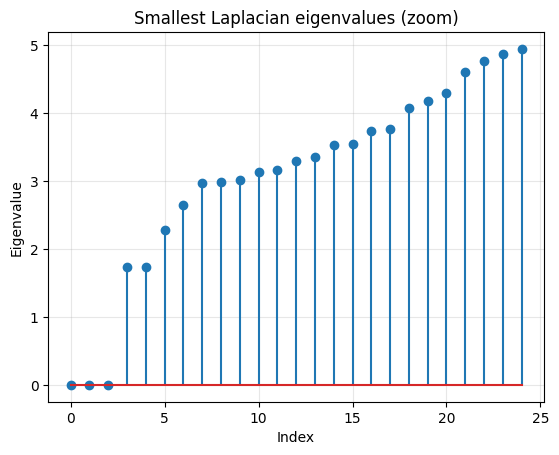

In [549]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


In [550]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def sample_igmrf(Theta: np.ndarray, n: int, rng=None):
    """
    Sample x ~ N(0, Theta^\dagger), where Theta is a Laplacian (PSD, singular).
    Uses pseudo-inverse covariance.
    """
    if rng is None:
        rng = np.random.default_rng(0)
    Sigma = np.linalg.pinv(Theta)
    X = rng.multivariate_normal(mean=np.zeros(Theta.shape[0]), cov=Sigma, size=n)
    return X

def sample_covariance(X: np.ndarray):
    # matches (67) in the paper: centered sample covariance :contentReference[oaicite:6]{index=6}
    Xc = X - X.mean(axis=0, keepdims=True)
    return (Xc.T @ Xc) / Xc.shape[0]

In [551]:
def weights_from_theta(Theta: np.ndarray, edges):
    # Theta_ij = -w_ij for i!=j, w>=0
    w = np.zeros(len(edges), dtype=float)
    for k, (i, j) in enumerate(edges):
        w[k] = max(-Theta[i, j], 0.0)
    return w

def relative_error(Theta_hat, Theta_true):
    return np.linalg.norm(Theta_hat - Theta_true, ord="fro") / (np.linalg.norm(Theta_true, ord="fro") + 1e-12)

def support_from_weights_quantile(w, q=0.9):
    """Return boolean mask for top (1-q)% edges."""
    w = np.asarray(w)
    pos = w[w > 0]
    if len(pos) == 0:
        return np.zeros_like(w, dtype=bool)
    thr = np.quantile(pos, q)
    return w >= thr

def f_score_from_thetas(Theta_hat, Theta_true, edges, q=0.9):
    
    w_hat = weights_from_theta(Theta_hat, edges)
    w_true = weights_from_theta(Theta_true, edges)

    pred = support_from_weights_quantile(w_hat, q)
    true = w_true > 0

    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)

    denom = (2*tp + fp + fn)
    return (2*tp / denom) if denom > 0 else 1.0

### SGL
SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [552]:
def phi_log(w, eps : float):
    return np.log(eps + w)

def sgl_objective(S: np.ndarray,
                  Lw: np.ndarray,
                  w: np.ndarray,
                  U: np.ndarray,
                  lam: np.ndarray,
                  alpha: float,
                  beta: float,
                  eps: float,
                  phi) -> float:
    """
    F(w,lam,U) =
      - log gdet(Diag(lam)) + tr(S Lw) + alpha * sum_i phi(w_i)
      + (beta/2) * ||Lw - U Diag(lam) U^T||_F^2
    """
    lam = np.asarray(lam, dtype=float)
    if np.any(lam <= 0):
        return np.inf  

    term_gdet = -np.sum(np.log(lam))                 
    term_trace = float(np.trace(S @ Lw))             
    term_sparse = float(alpha * np.sum(phi(w, eps)))      

    B = U @ np.diag(lam) @ U.T
    term_pen = 0.5 * beta * (np.linalg.norm(Lw - B, ord="fro") ** 2)

    return term_gdet + term_trace + term_sparse + term_pen

In [553]:
def w_init_naive_from_S(S: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Repo's 'naive' init: w_ij = max(0, -pinv(S)_{ij})
    """
    Sinv = np.linalg.pinv(S)
    m = len(edges)
    w0 = np.zeros(m, dtype=float)
    for e, (i, j) in enumerate(edges):
        w0[e] = max(-Sinv[i, j], 0.0)
    # small epsilon to avoid degenerate Lw at start (optional)
    w0 += 1e-12
    return w0

In [554]:
def U_update(Lw: np.ndarray, k: int):
    evals, evecs = np.linalg.eigh(Lw)
    return evecs[:, k:], evals

In [555]:
def lambda_update_closed_form(d: np.ndarray, beta: float, c1: float, c2: float):
    d = np.asarray(d, dtype=float)
    lam = 0.5 * (d + np.sqrt(d*d + 4.0/beta))
    lam = np.clip(lam, c1, c2)

    # repo guardrail: lambda must be nondecreasing
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta.")
    return lam

In [556]:
def apply_M(v: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    M v = L*(L(v)), where L(v) is a Laplacian built from weight-vector v.
    """
    Lv = L_operator(v, p, edges)
    return L_adjoint(Lv, p, edges)

In [557]:
def w_update_repo_style(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, lam: np.ndarray,
                        beta: float, K: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    Mirrors R's laplacian.w_update:
      c = L*(U diag(lam) U^T - K/beta)
      grad_f = L*(Lw) - c
      t = (w^T M grad_f - c^T grad_f) / (grad_f^T M grad_f)
      w <- (w - t grad_f)_+
    """
    ULmdUT = U @ np.diag(lam) @ U.T
    c = L_adjoint(ULmdUT - (K / beta), p, edges)

    grad_f = L_adjoint(Lw, p, edges) - c
    M_grad_f = apply_M(grad_f, p, edges)

    denom = float(np.dot(grad_f, M_grad_f))
    if denom <= 1e-18 or not np.isfinite(denom):
        return np.maximum(w, 0.0)

    numer = float(np.dot(w, M_grad_f) - np.dot(c, grad_f))
    t = numer / denom

    w_new = np.maximum(w - t * grad_f, 0.0)
    return w_new

In [558]:
def sgl_r_style(S: np.ndarray,
                k: int,
                beta: float = 400.0,
                alpha: float = 0.1,
                eps: float = 1e-4,
                c1: float = 1e-9,
                c2: float = 1e9,
                maxiter: int = 200,
                reltol: float = 1e-6,
                w0: np.ndarray | None = None,
                verbose: bool = True):

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    edges = edge_list(p)
    m = len(edges)

    # ---- init w ----
    if w0 is None:
        w = w_init_naive_from_S(S, edges)   # IMPORTANT
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    # H and K (reweighted l1 surrogate) like repo
    H = alpha * (np.eye(p) - np.ones((p, p)))

    # initial Lw, U, lam
    Lw = L_operator(w, p, edges)
    U, evals = U_update(Lw, k)
    d = np.diag(U.T @ Lw @ U)
    lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

    # K update (safe division)
    denom = (-Lw + eps)
    K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

    hist = {"relchg_w": [], "penalty": [], "eig_k": [], "step": []}

    for it in range(maxiter):
        w_old = w.copy()

        # ----- w-update (repo style) -----
        w = w_update_repo_style(w, Lw, U, lam, beta, K, p, edges)

        # ----- update Lw, U, lam -----
        Lw = L_operator(w, p, edges)
        U, evals = U_update(Lw, k)
        d = np.diag(U.T @ Lw @ U)
        lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

        # ----- update K (safe) -----
        denom = (-Lw + eps)
        K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

        # ----- logging / stopping -----
        relchg = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
        hist["relchg_w"].append(relchg)
        hist["penalty"].append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))
        hist["eig_k"].append(evals[k] if k < len(evals) else np.nan)

        if verbose and (it % 10 == 0 or it == maxiter - 1):
            print(f"[it={it:03d}] relchg(w)={relchg:.3e}, eig[k]={hist['eig_k'][-1]:.3e}")

        if relchg < reltol:
            break

    return Lw, w, U, lam, hist

Application to noisy graphs

In [559]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er


[it=000] relchg(w)=1.426e-02, eig[k]=2.085e+01
[it=010] relchg(w)=8.248e-03, eig[k]=1.850e+01
[it=020] relchg(w)=5.686e-03, eig[k]=1.741e+01
[it=030] relchg(w)=4.147e-03, eig[k]=1.682e+01
[it=040] relchg(w)=3.378e-03, eig[k]=1.636e+01
[it=050] relchg(w)=2.649e-03, eig[k]=1.602e+01
[it=060] relchg(w)=2.227e-03, eig[k]=1.578e+01
[it=070] relchg(w)=1.856e-03, eig[k]=1.564e+01
[it=080] relchg(w)=1.542e-03, eig[k]=1.554e+01
[it=090] relchg(w)=1.347e-03, eig[k]=1.545e+01
[it=100] relchg(w)=1.170e-03, eig[k]=1.538e+01
[it=110] relchg(w)=1.028e-03, eig[k]=1.532e+01
[it=120] relchg(w)=9.495e-04, eig[k]=1.526e+01
[it=130] relchg(w)=8.644e-04, eig[k]=1.522e+01
[it=140] relchg(w)=7.712e-04, eig[k]=1.519e+01
[it=150] relchg(w)=7.346e-04, eig[k]=1.516e+01
[it=160] relchg(w)=6.474e-04, eig[k]=1.513e+01
[it=170] relchg(w)=6.125e-04, eig[k]=1.510e+01
[it=180] relchg(w)=5.622e-04, eig[k]=1.508e+01
[it=190] relchg(w)=5.493e-04, eig[k]=1.505e+01
[it=200] relchg(w)=4.996e-04, eig[k]=1.503e+01
[it=210] relc

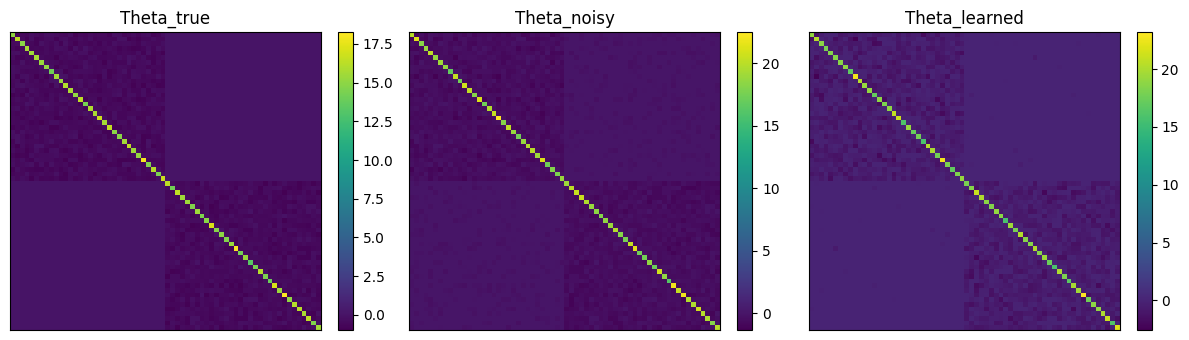

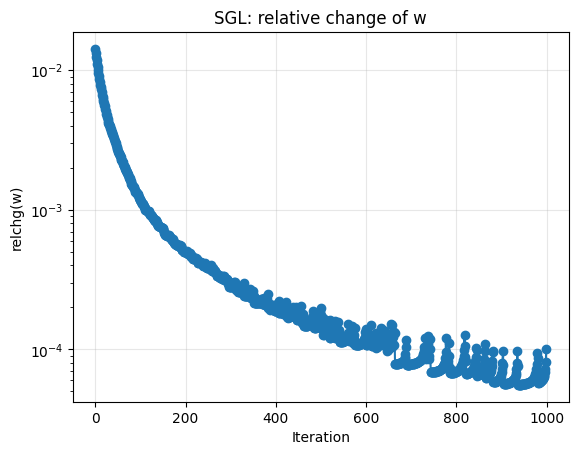

In [560]:
rng = np.random.default_rng(1)

p = 64
k_true = 2

# true multi-component Laplacian
W_true, Theta_true = make_block_k_component_laplacian(p=p, k=k_true, w_low=0.0, w_high=1.0, rng=rng)

# ER noise Laplacian (paper uses this corruption model)
W_er, Theta_er = make_er_noise_laplacian(p=p, p_edge=0.25, kappa=0.45, rng=rng)

Theta_noisy = Theta_true + Theta_er

# sample data from IGMRF and compute SCM (eq. 67)
n = 30 * p
X = sample_igmrf(Theta_noisy, n=n, rng=rng)
S = sample_covariance(X)

# run SGL (paper-like hyperparams for this scenario)
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S, k=k_true,
    beta=400.0, alpha=0.1, eps=1e-4,
    c1=1e-9, c2=1e9,
    maxiter=1000, reltol=1e-6,
    verbose=True
)

# metrics
edges = edge_list(p)
re = relative_error(Theta_hat, Theta_true)
fs = f_score_from_thetas(Theta_hat, Theta_true, edges)
print(f"\nRE={re:.3f}, F-score={fs:.3f}")

# plots: heatmaps like the paper
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, M, title in zip(
    axes,
    [Theta_true, Theta_noisy, Theta_hat],
    ["Theta_true", "Theta_noisy", "Theta_learned"]
):
    im = ax.imshow(M, aspect="auto")
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

# convergence diagnostics
plt.figure()
plt.semilogy(hist["relchg_w"], marker="o")
plt.title("SGL: relative change of w")
plt.xlabel("Iteration")
plt.ylabel("relchg(w)")
plt.grid(True, alpha=0.3)
plt.show()


In [561]:
def adjacency_from_theta(Theta: np.ndarray, thr_quantile: float = 0.90) -> np.ndarray:
    """
    Recover adjacency matrix W from Laplacian Theta.
    Threshold by quantile on positive weights.
    """
    # off-diagonal weights
    W = np.maximum(-Theta, 0.0)
    np.fill_diagonal(W, 0.0)

    # threshold (to visualize / binarize structure)
    positive = W[W > 0]
    if positive.size == 0:
        return W

    thr = np.quantile(positive, thr_quantile)
    print(f"[adjacency_from_theta] threshold = {thr:.4g}")

    W[W < thr] = 0.0
    return W

[adjacency_from_theta] threshold = 1.305


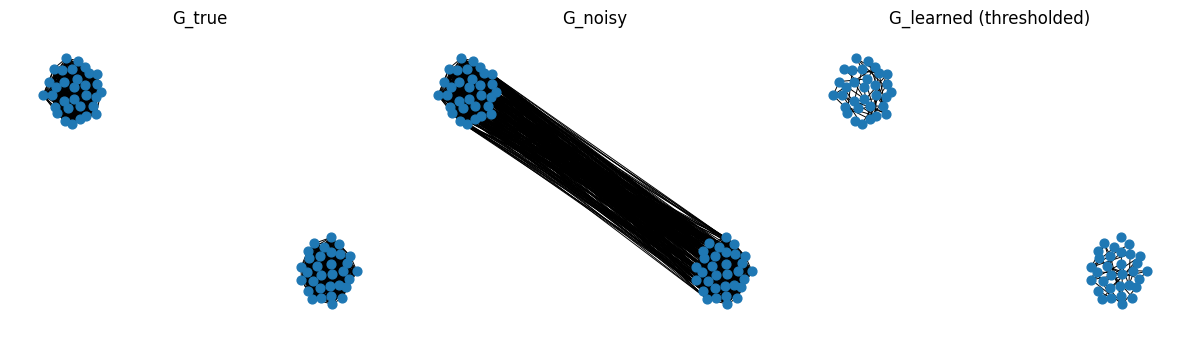

In [562]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.90)

G_true = nx.from_numpy_array(np.maximum(W_true, 0.0))
G_noisy = nx.from_numpy_array(np.maximum(W_true + W_er, 0.0))
G_hat = nx.from_numpy_array(np.maximum(W_hat, 0.0))

pos = nx.spring_layout(G_true, seed=0)

plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
nx.draw(G_true, pos, node_size=40, width=0.7)
plt.title("G_true")
plt.axis("off")

plt.subplot(1, 3, 2)
nx.draw(G_noisy, pos, node_size=40, width=0.7)
plt.title("G_noisy")
plt.axis("off")

plt.subplot(1, 3, 3)
nx.draw(G_hat, pos, node_size=40, width=0.7)
plt.title("G_learned (thresholded)")
plt.axis("off")

plt.tight_layout()
plt.show()


### Animal Dataset

In [605]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [606]:
A_animals = np.asarray(A_animals)
print("A_animals shape:", A_animals.shape)

# convention: rows=features, cols=animals? you used transpose so keep same
X_animals = A_animals.T

mu = X_animals.mean(axis=0, keepdims=True)

Xz = (X_animals - mu) 

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
print("S_animals shape:", S_animals.shape)

# small diagonal loading (like you did)
S_in_animals = S_animals + (1/3) * np.eye(p)

A_animals shape: (50, 85)
S_animals shape: (50, 50)


In [623]:
Theta_hat_animals, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S_in_animals,
    k=12,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    reltol=1e-5,
    maxiter=1000,
    verbose=True
)
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.90)

[it=000] relchg(w)=1.611e-01, eig[k]=1.887e+00
[it=010] relchg(w)=3.103e-02, eig[k]=6.660e-01
[it=020] relchg(w)=1.441e-02, eig[k]=5.722e-01
[it=030] relchg(w)=9.057e-03, eig[k]=5.409e-01
[it=040] relchg(w)=6.310e-03, eig[k]=5.284e-01
[it=050] relchg(w)=5.318e-03, eig[k]=5.165e-01
[it=060] relchg(w)=4.729e-03, eig[k]=5.094e-01
[it=070] relchg(w)=3.680e-03, eig[k]=5.034e-01
[it=080] relchg(w)=3.053e-03, eig[k]=5.041e-01
[it=090] relchg(w)=2.213e-03, eig[k]=5.035e-01
[it=100] relchg(w)=1.833e-03, eig[k]=4.997e-01
[it=110] relchg(w)=1.691e-03, eig[k]=4.940e-01
[it=120] relchg(w)=1.623e-03, eig[k]=4.887e-01
[it=130] relchg(w)=1.437e-03, eig[k]=4.833e-01
[it=140] relchg(w)=1.226e-03, eig[k]=4.792e-01
[it=150] relchg(w)=1.171e-03, eig[k]=4.756e-01
[it=160] relchg(w)=9.801e-04, eig[k]=4.720e-01
[it=170] relchg(w)=8.595e-04, eig[k]=4.686e-01
[it=180] relchg(w)=8.240e-04, eig[k]=4.654e-01
[it=190] relchg(w)=8.062e-04, eig[k]=4.628e-01
[it=200] relchg(w)=8.037e-04, eig[k]=4.607e-01
[it=210] relc

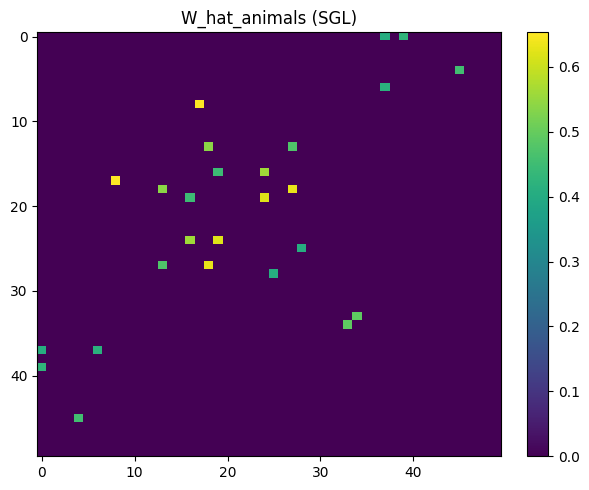

In [624]:
plt.figure(figsize=(6,5))
plt.imshow(W_hat_animals, aspect="auto")
plt.title("W_hat_animals (SGL)")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

In [649]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.55)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

[adjacency_from_theta] threshold = 0.2068


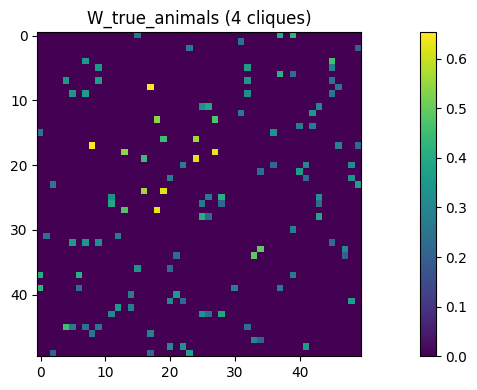

In [650]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [651]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 13


In [652]:
animal_names = [
    "antelope",
    "grizzly bear",
    "killer whale",
    "beaver",
    "dalmatian",
    "persian cat",
    "horse",
    "german shepherd",
    "blue whale",
    "siamese cat",
    "skunk",
    "mole",
    "tiger",
    "hippopotamus",
    "leopard",
    "moose",
    "spider monkey",
    "humpback whale",
    "elephant",
    "gorilla",
    "ox",
    "fox",
    "sheep",
    "seal",
    "chimpanzee",
    "hamster",
    "squirrel",
    "rhinoceros",
    "rabbit",
    "bat",
    "giraffe",
    "wolf",
    "chihuahua",
    "rat",
    "weasel",
    "otter",
    "buffalo",
    "zebra",
    "giant panda",
    "deer",
    "bobcat",
    "pig",
    "lion",
    "mouse",
    "polar bear",
    "collie",
    "walrus",
    "raccoon",
    "cow",
    "dolphin",
]
labels = {i: animal_names[i] for i in range(len(animal_names))}

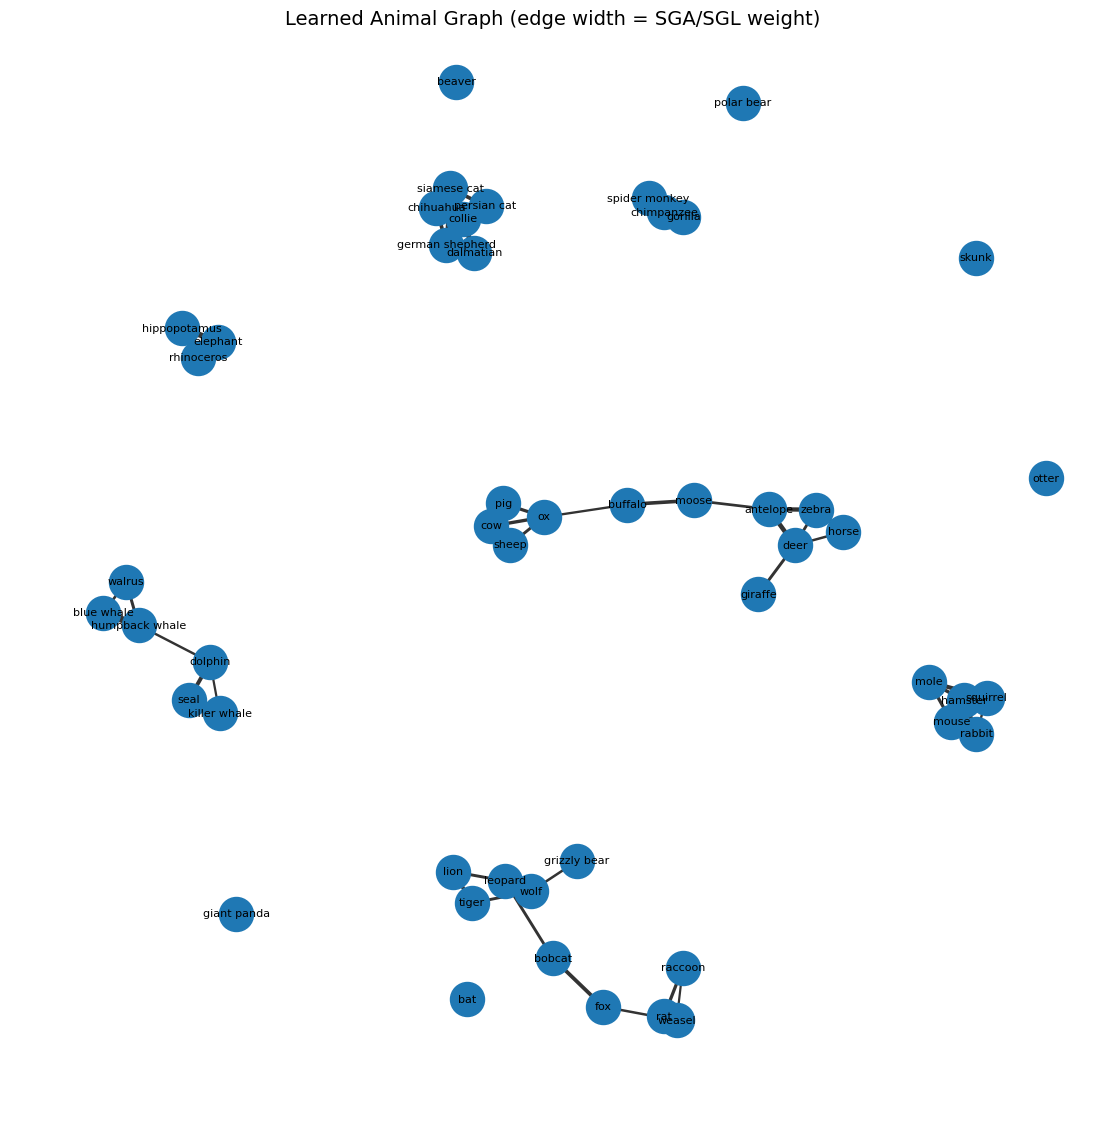

In [658]:
plt.figure(figsize=(14, 14))

pos = nx.spring_layout(G_hat_animals, seed=0)

edges = list(G_hat_animals.edges())
weights = [G_hat_animals[u][v]["weight"] for u, v in edges]

weights = np.array(weights)
if len(weights) > 0:
    widths = 5.0 * weights / weights.max()
else:
    widths = 1.0

# Draw nodes
nx.draw_networkx_nodes(
    G_hat_animals,
    pos,
    node_size=600,
)

# Draw edges with widths = learned weights
nx.draw_networkx_edges(
    G_hat_animals,
    pos,
    edgelist=edges,
    width=widths,
    alpha=0.8,
)

# Draw labels
nx.draw_networkx_labels(
    G_hat_animals,
    pos,
    labels=labels,
    font_size=8,
)

plt.title("Learned Animal Graph (edge width = SGA/SGL weight)", fontsize=14)
plt.axis("off")
plt.show()


### Moons, circles and clusters

In [659]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.3

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

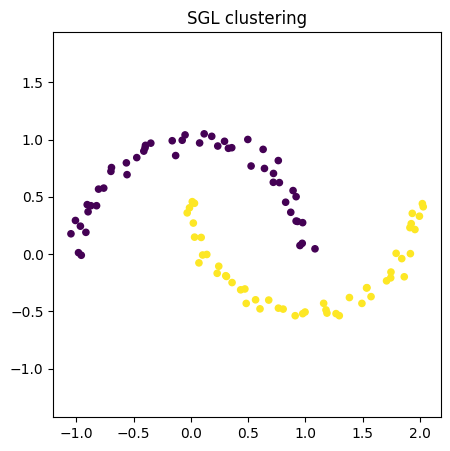

In [660]:
plt.figure(figsize=(5,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

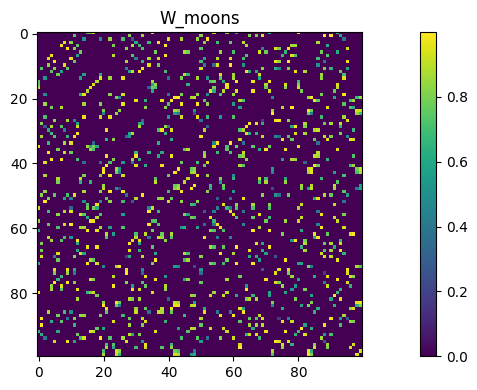

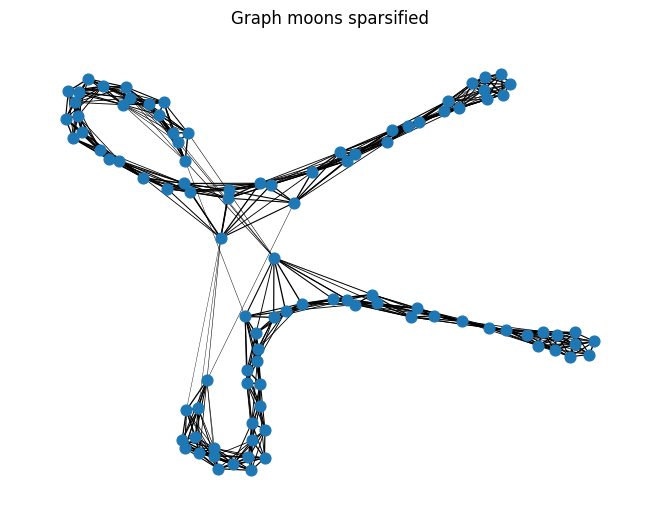

In [661]:
W_moons = gaussian_similarity(X_moons)
Theta_moons = laplacian_from_W(W_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

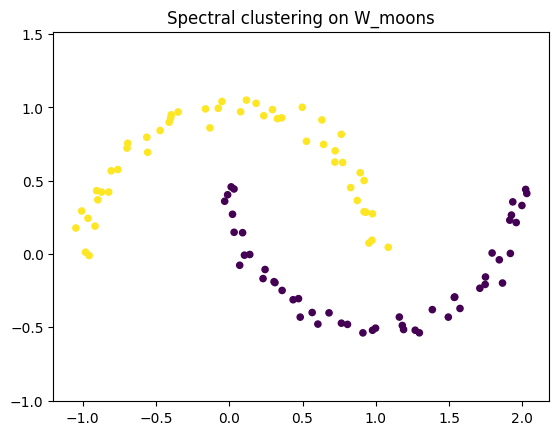

In [662]:
from sklearn.cluster import SpectralClustering

labels_sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

In [663]:
p = W_moons.shape[0]

L_init = laplacian_from_W(W_moons)
S_moons = np.linalg.pinv(W_moons) + 1/3 * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons, _ = sgl_r_style(
    S=S_moons,
    k=2,
    alpha=0.1,     
    beta=50,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=1000,
)

[it=000] relchg(w)=8.121e-03, eig[k]=3.208e-01
[it=010] relchg(w)=2.180e-03, eig[k]=2.637e-01
[it=020] relchg(w)=1.753e-03, eig[k]=2.511e-01
[it=030] relchg(w)=1.325e-03, eig[k]=2.416e-01
[it=040] relchg(w)=1.324e-03, eig[k]=2.391e-01
[it=050] relchg(w)=1.270e-03, eig[k]=2.325e-01
[it=060] relchg(w)=1.102e-03, eig[k]=2.274e-01
[it=070] relchg(w)=1.003e-03, eig[k]=2.298e-01
[it=080] relchg(w)=9.940e-04, eig[k]=2.323e-01
[it=090] relchg(w)=9.511e-04, eig[k]=2.351e-01
[it=100] relchg(w)=1.089e-03, eig[k]=2.380e-01
[it=110] relchg(w)=8.970e-04, eig[k]=2.410e-01
[it=120] relchg(w)=9.968e-04, eig[k]=2.442e-01
[it=130] relchg(w)=9.350e-04, eig[k]=2.473e-01
[it=140] relchg(w)=8.304e-04, eig[k]=2.505e-01
[it=150] relchg(w)=9.188e-04, eig[k]=2.539e-01
[it=160] relchg(w)=7.975e-04, eig[k]=2.572e-01
[it=170] relchg(w)=7.958e-04, eig[k]=2.606e-01
[it=180] relchg(w)=7.601e-04, eig[k]=2.639e-01
[it=190] relchg(w)=8.661e-04, eig[k]=2.672e-01
[it=200] relchg(w)=9.145e-04, eig[k]=2.705e-01
[it=210] relc

In [687]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons, thr_quantile=0.785)
G_hat_moons = nx.from_numpy_array(W_hat_moons)

[adjacency_from_theta] threshold = 0.8856


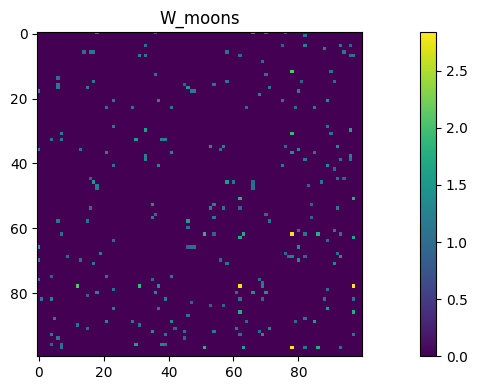

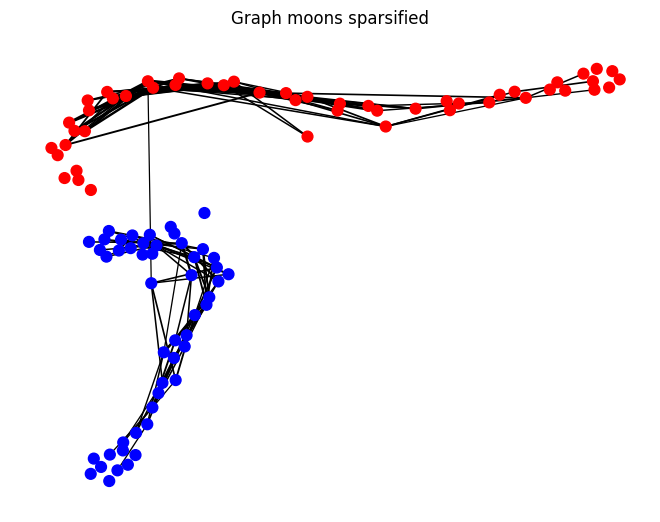

In [691]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [692]:
re = relative_error(Theta_hat_moons, Theta_moons)
fs = f_score_from_thetas(Theta_hat_moons, Theta_moons, edges)
print(f"The residual score is: {re} and the f1 score is: {fs}")

The residual score is: 0.574074050419238 and the f1 score is: 0.1889763779527559


### Circles

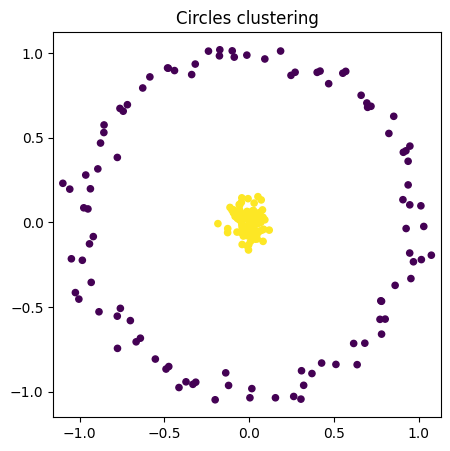

In [693]:
plt.figure(figsize=(5,5))
plt.scatter(X_circles[:,0], X_circles[:,1], c=labels_true_circles, s=20)
plt.title("Circles clustering")
plt.axis("equal")
plt.show()

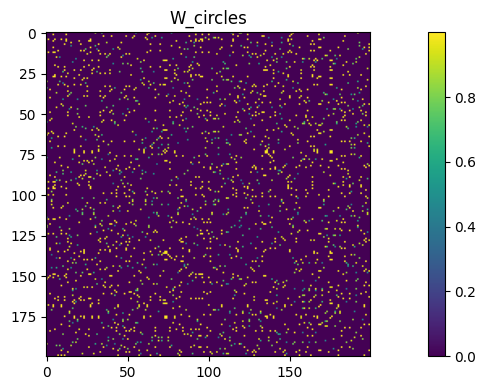

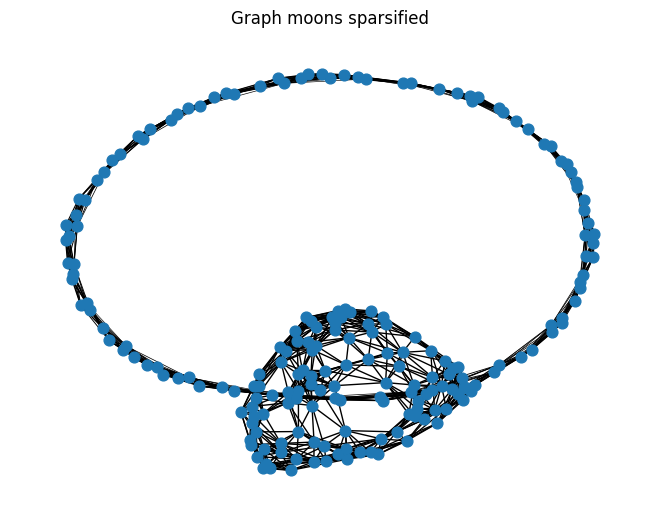

In [580]:
W_circles = gaussian_similarity(X_circles)
W_circles = knn_sparsify(W_circles, k=10)
G_circles = nx.from_numpy_array(W_circles)

plt.figure(figsize=(12,4))


plt.imshow(W_circles)
plt.title("W_circles")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_circles.edges())
p = W_circles.shape[0]
weights_circles = np.array([G_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [581]:
p = W_circles.shape[0]
S_circles = np.linalg.pinv(W_circles) + (1/3) * np.eye(p)

Theta_hat_circles, w_hat_circles, U_hat_circles, lam_hat_circles, _ = sgl_r_style(
    S=S_circles,
    k=2,
    alpha=0.1,     
    beta=1e2,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=500,
)

[it=000] relchg(w)=4.119e-04, eig[k]=4.547e-01
[it=010] relchg(w)=1.480e-04, eig[k]=4.173e-01
[it=020] relchg(w)=1.164e-04, eig[k]=3.986e-01
[it=030] relchg(w)=9.272e-05, eig[k]=3.868e-01
[it=040] relchg(w)=9.749e-05, eig[k]=3.772e-01
[it=050] relchg(w)=7.661e-05, eig[k]=3.698e-01
[it=060] relchg(w)=6.457e-05, eig[k]=3.652e-01
[it=070] relchg(w)=7.504e-05, eig[k]=3.611e-01
[it=080] relchg(w)=6.198e-05, eig[k]=3.572e-01
[it=090] relchg(w)=6.467e-05, eig[k]=3.537e-01
[it=100] relchg(w)=5.250e-05, eig[k]=3.507e-01
[it=110] relchg(w)=4.928e-05, eig[k]=3.486e-01
[it=120] relchg(w)=5.055e-05, eig[k]=3.465e-01
[it=130] relchg(w)=5.035e-05, eig[k]=3.442e-01
[it=140] relchg(w)=5.088e-05, eig[k]=3.421e-01
[it=150] relchg(w)=4.821e-05, eig[k]=3.399e-01
[it=160] relchg(w)=5.361e-05, eig[k]=3.379e-01
[it=170] relchg(w)=4.918e-05, eig[k]=3.361e-01
[it=180] relchg(w)=4.135e-05, eig[k]=3.343e-01
[it=190] relchg(w)=4.337e-05, eig[k]=3.327e-01
[it=200] relchg(w)=3.945e-05, eig[k]=3.311e-01
[it=210] relc

In [582]:
W_hat_circles = adjacency_from_theta(Theta_hat_circles)
G_hat_circles = nx.from_numpy_array(W_hat_circles)

[adjacency_from_theta] threshold = 2.597


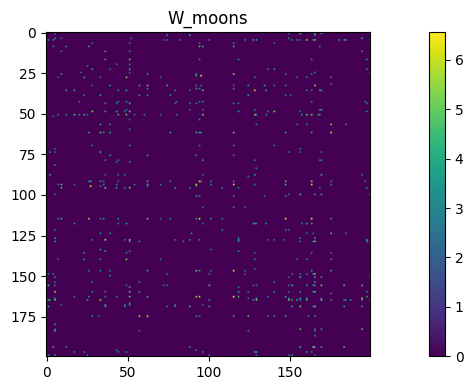

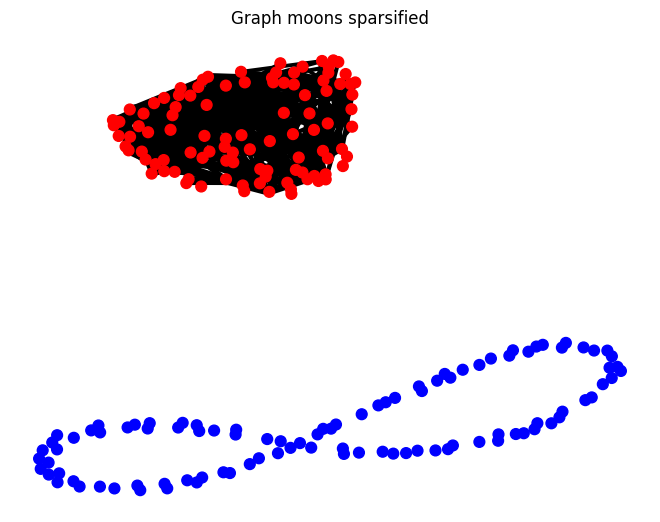

In [583]:
color_map = list()
for label in labels_true_circles:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_circles)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_hat_circles.edges())
p = W_hat_circles.shape[0]
weights_circles = np.array([G_hat_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_hat_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

### SGA Algorithm